In [26]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

plt.rcParams["figure.figsize"] = (20,15)

Text(0.5, 1.0, 'Density of Particle Counts vs Time')

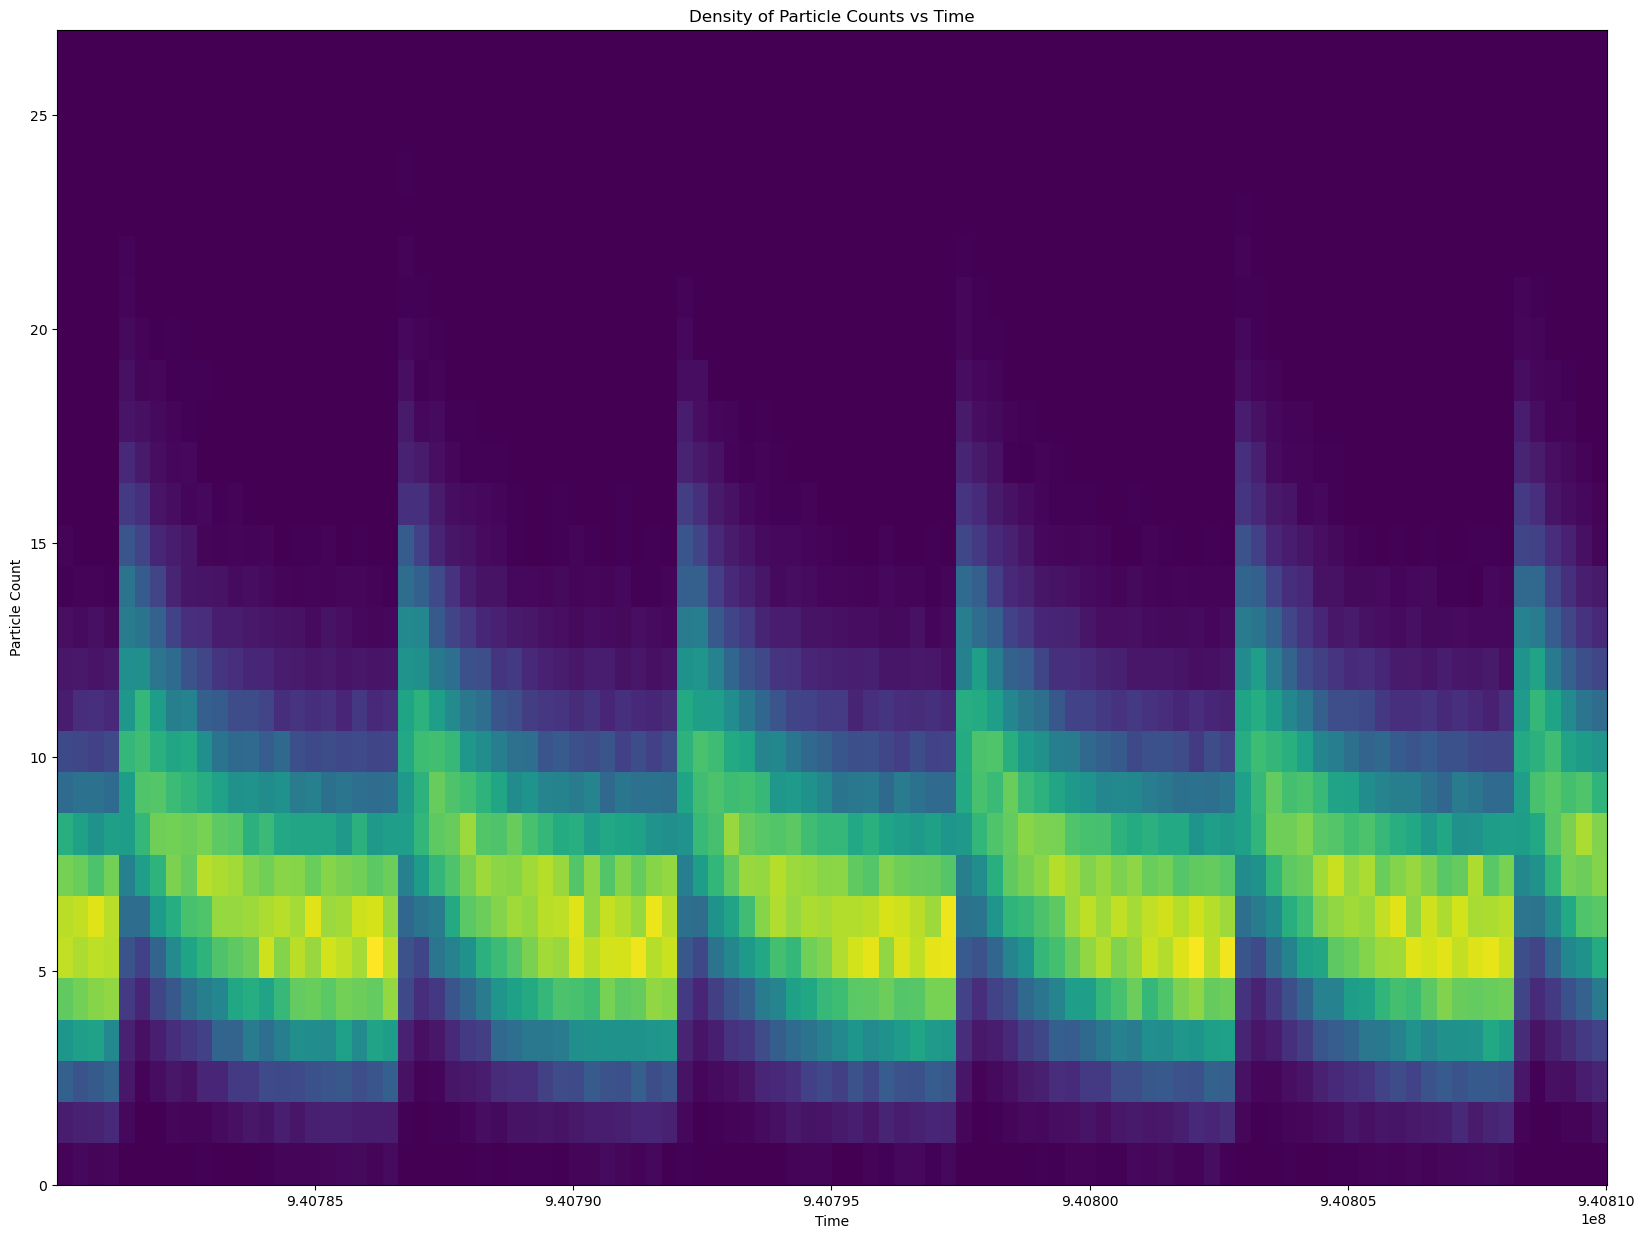

In [176]:
# Problem 1.1:

hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys()
data = np.array(hf.get('data'))

time = data[0,1000000:1300000]
particles = data[3,1000000:1300000]
earth_longitude = data[2,1000000:1300000]

fig, ax = plt.subplots(1)
ax.hist2d(time, particles, bins=[100,28], density=True)
plt.xlabel('Time')
plt.ylabel('Particle Count')
plt.title('Density of Particle Counts vs Time')

The above plot shows the density of various particle counts based on time, it is hard to determine the background distribution from this, but is appears to be a poisson. It can also be seen that the distribution changes periodically in time. This also shows a zoomed in section of the data, as zoomed out there seems to be no pattern in the data.

Text(0.5, 1.0, 'Density of Particle Counts vs Solar Phase')

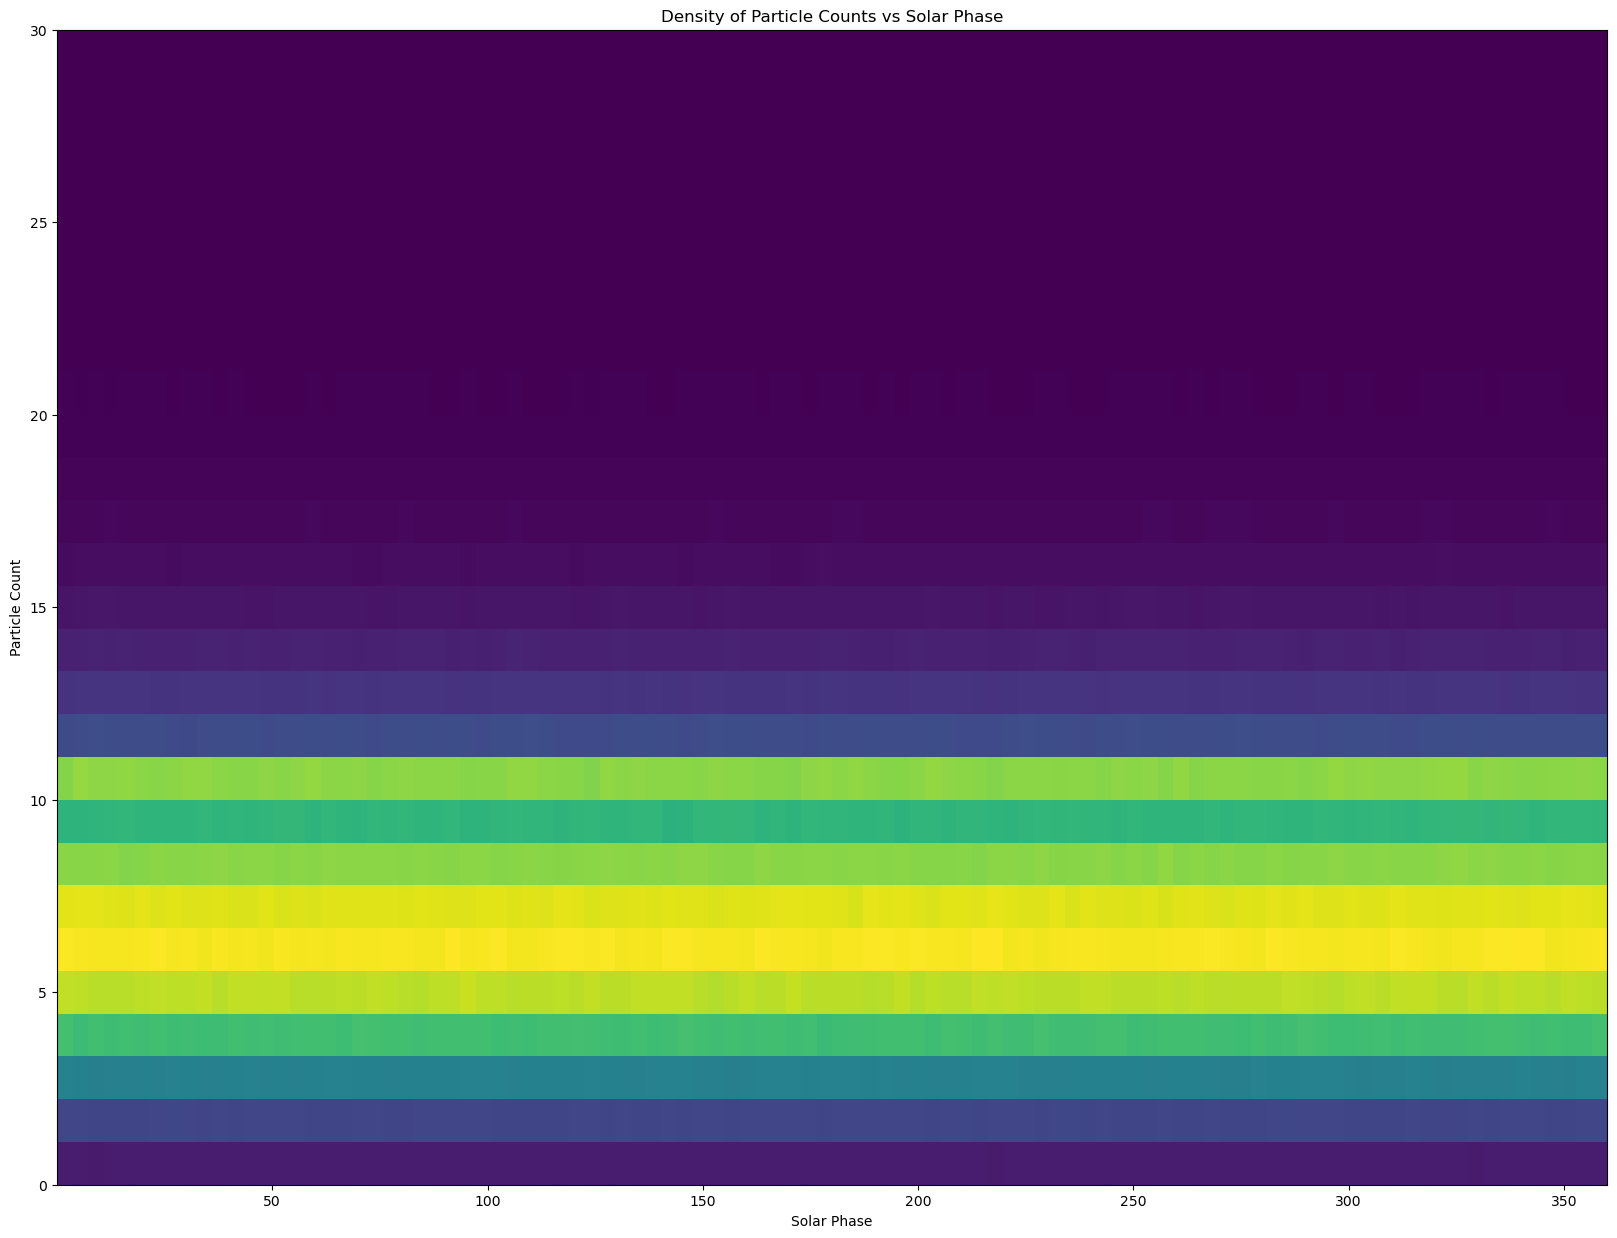

In [177]:
particles = data[3,:]
solar_phase = data[1,:]

fig, ax = plt.subplots(1)
ax.hist2d(solar_phase, particles, bins=[100,27], density=True)
plt.xlabel('Solar Phase')
plt.ylabel('Particle Count')
plt.title('Density of Particle Counts vs Solar Phase')

The above plot shows the density of particle counts based on solar phase, it can be seen that the mean does not vary at all due to the solar phase, so it would not be useful to use the solar phase to create a model of the background.

Text(0.5, 1.0, 'Density of Particle counts vs Earth Longitude')

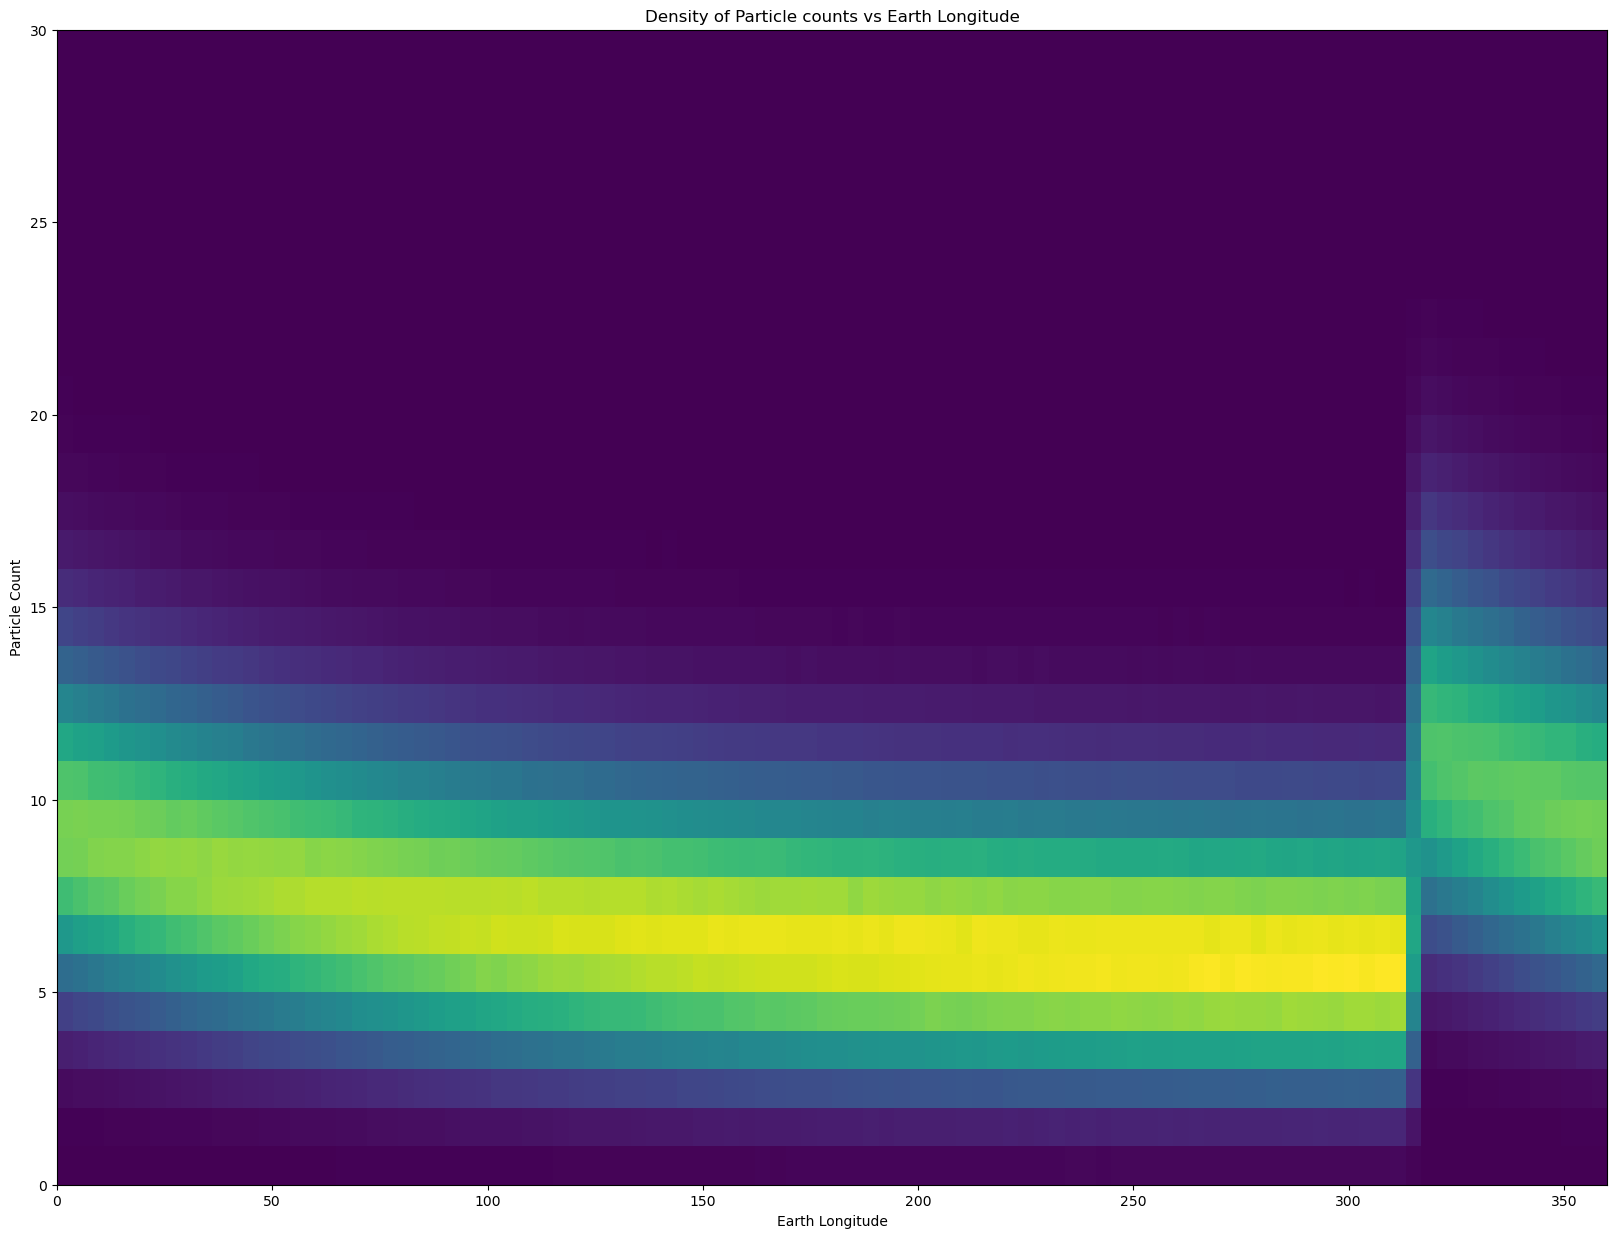

In [175]:
particles = data[3,:]
earth_longitude = data[2,:]

fig, ax = plt.subplots(1)
ax.hist2d(earth_longitude, particles, bins=[100,30], density=True)
plt.xlabel('Earth Longitude')
plt.ylabel('Particle Count')
plt.title('Density of Particle counts vs Earth Longitude')

The above plot shows the density of Particle counts based on the location of the satellite around the earth. The mean of the distributions which is where it is densest appears to follow a negative exponential curve. It also appears to follow the same shape as the time dependency plot, but only shows one period, making it more viable to use the longitude to create a model of the background distribution.

Text(0.5, 1.0, 'Longitude dependence on Time')

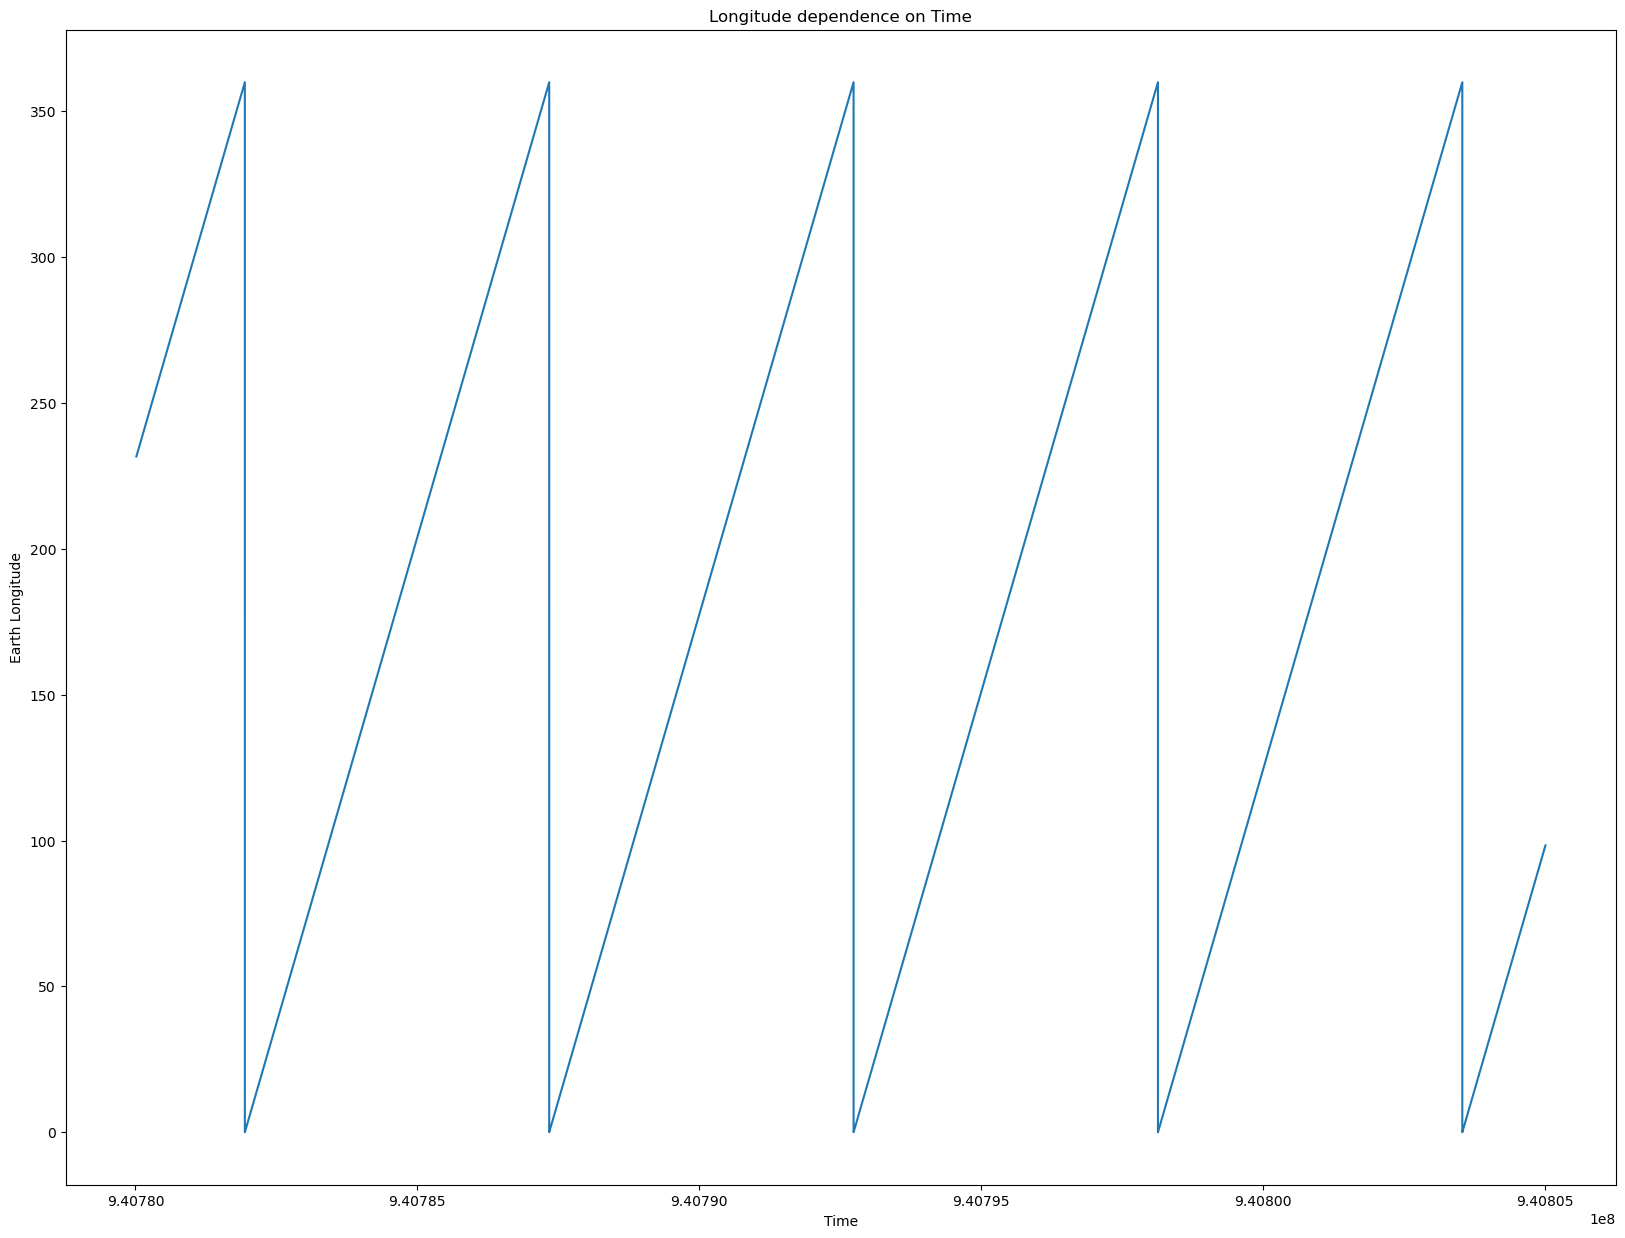

In [178]:
time = data[0,1000000:1250000]
earth_longitude = data[2,1000000:1250000]

fig, ax = plt.subplots(1)
ax.plot(time, earth_longitude)
plt.xlabel('Time')
plt.ylabel('Earth Longitude')
plt.title('Longitude dependence on Time')

The above plot shows the relationship between the location of the satellite and time. It can be seen that the longitude increases linearly, and resets periodically.

In [98]:
long = data[2,1000000:1250000]
time = data[0,1000000:1250000]

long_max = np.max(long)
long_min = np.min(long)

start_period_index = np.where(long == long_min)[0][0]
end_period_index = np.where(long == long_max)[0][1]

start_period_time = time[start_period_index]
end_period_time = time[end_period_index]

period_length = end_period_time - start_period_time

print(period_length)

linear_slope = long_max/period_length
print(linear_slope)

5399.899999976158
0.0666666666666667


The Longitude has a periodic linear dependence on time with a period of 5399.899999976158 GPS seconds, which is equal to about 90 minutes. It has a slope of 0.0666666666666667 degrees per second.

Text(0.5, 1.0, 'Longitude dependence of Mean of Background distribution')

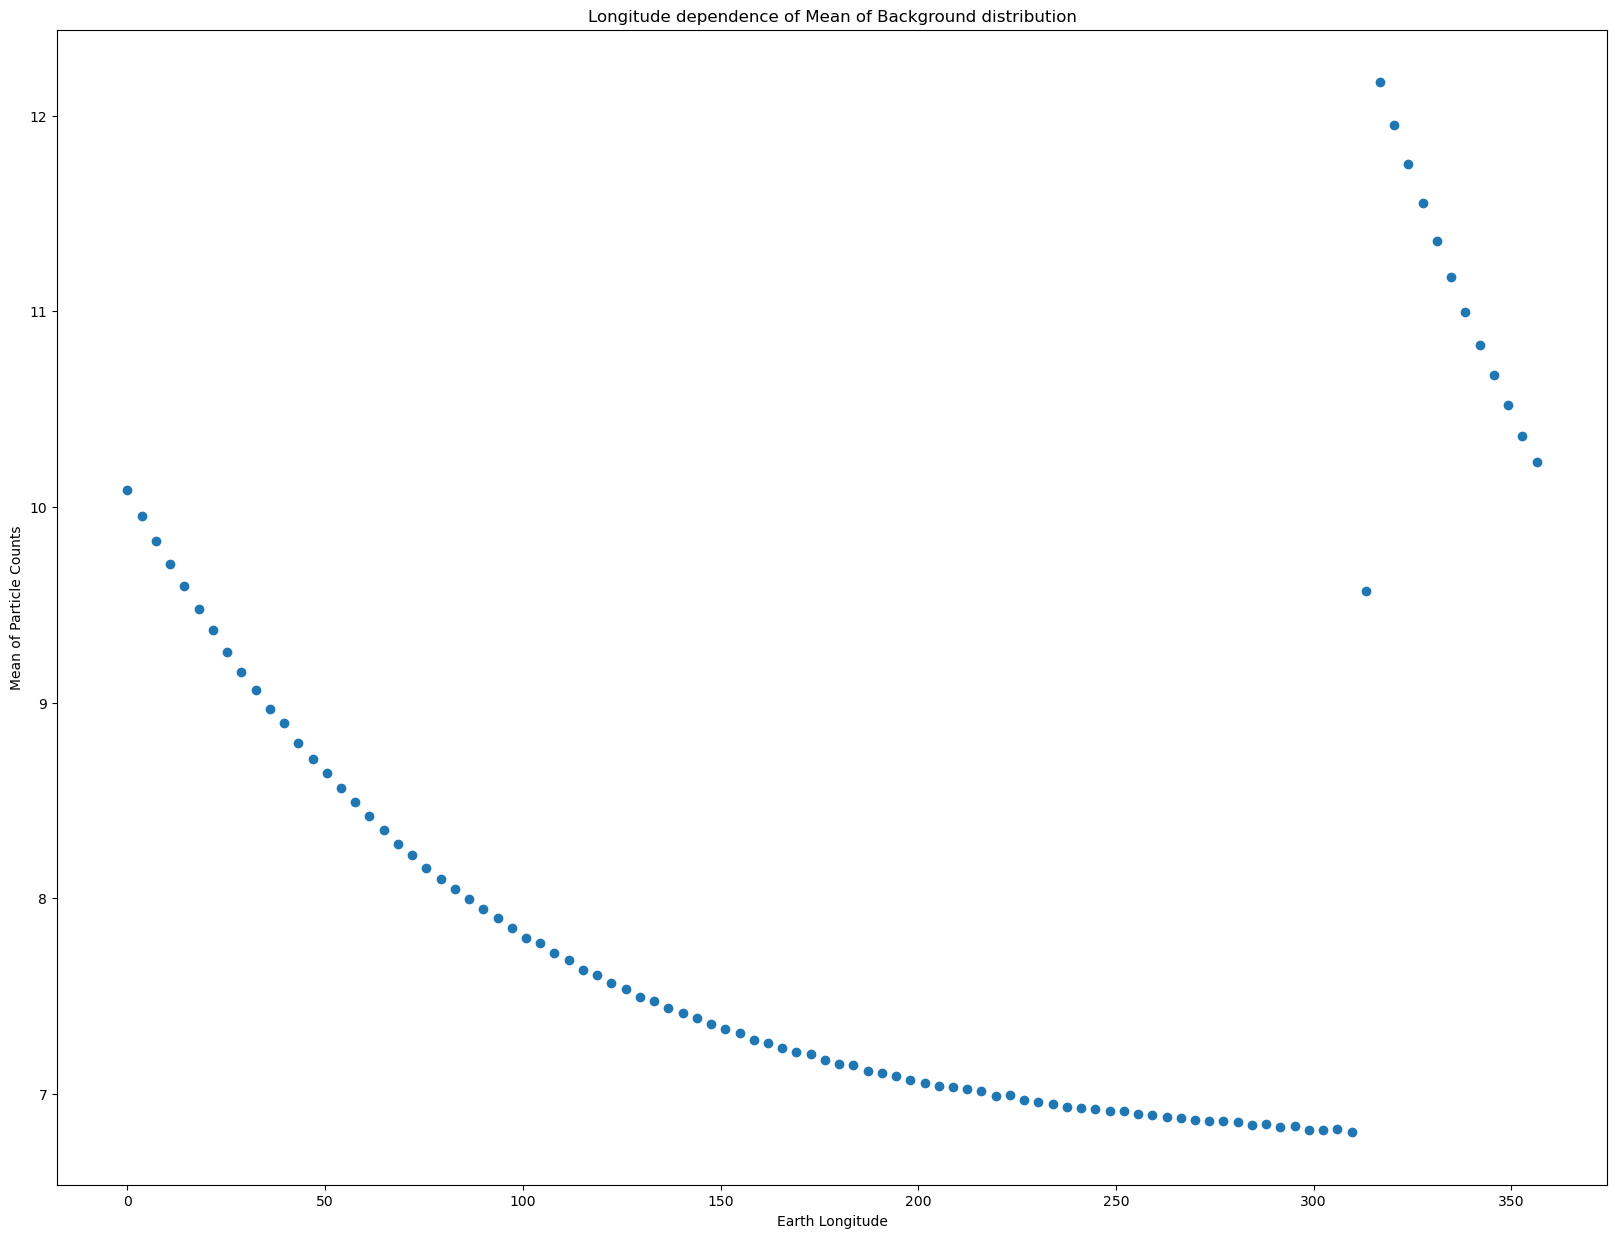

In [172]:
particles = data[3,:]
earth_longitude = data[2,:]

density_array = np.histogram2d(earth_longitude, particles, bins=[100,30])[0]
means = []

for i in range(100):
    sum = 0
    for k in range(30):
        sum += density_array[i][k]*(k+1)
    means.append(sum/259200.0) # 259200.0 is the total sample size of the particle counts

fig, ax = plt.subplots(1)
ax.scatter(np.arange(0,360, 3.6), means)
plt.xlabel('Earth Longitude')
plt.ylabel('Mean of Particle Counts')
plt.title('Longitude dependence of Mean of Background distribution')

The above plot  shows how the means of the background distribution varies as the location of the satellite orbits around the earth. This plot matches up well with the densist points of the 2D histogram showing the density of particle counts compared to the longitude of the satellite.

In [173]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

i = 0
while i <= 11:
    mean = means.pop()
    means.insert(0, mean)
    i += 1
    
popt, pcov = scipy.optimize.curve_fit(func, np.arange(-36,324,3.6), means)
print(popt)

[3.53344491 0.01184293 6.81890831]


Text(0.5, 1.0, 'Function of Longitude dependence for Mean of Background distribution')

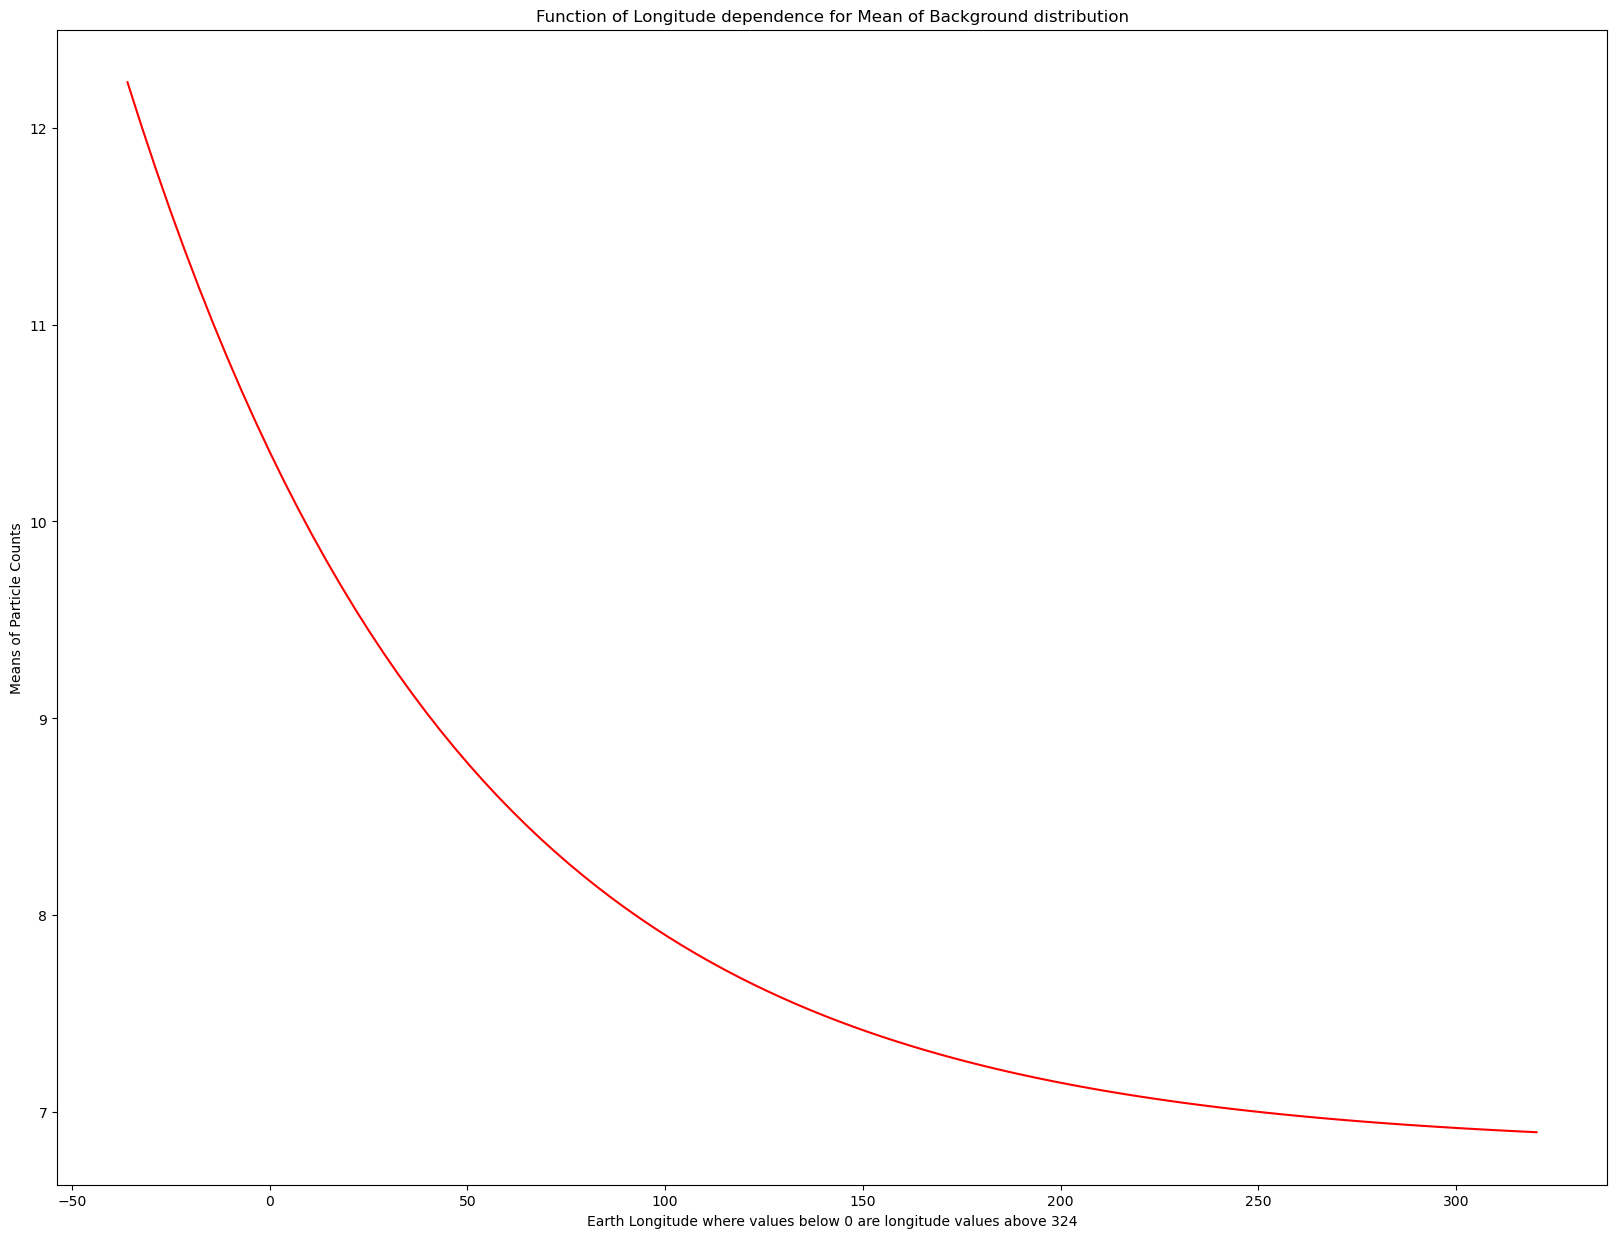

In [174]:
plt.plot(np.arange(-36,324,3.6), func(np.arange(-36,324,3.6), *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.ylabel('Means of Particle Counts')
plt.xlabel('Earth Longitude where values below 0 are longitude values above 324')
plt.title('Function of Longitude dependence for Mean of Background distribution')

I noticed that the means followed a negative exponential curve, that spikes up when the longitude is above 324, and this spike would flow smoothly into the values starting at 0. Because of this, I chose to move the means at longitudes greater than 324 to below 0, and then map a negative exponential function to find the longitude dependence on the means. After shifting the values, the particle count has a relationship depending on the longitude that follows the equation a*e^(-bx) + c where a = -3.53344491, b = 0.01184293, and c = 6.81890831. To get the time dependence of the background distribution, we just need to plug in the equation for the longitudes time dependence which is L = 0.0666666666666667t, so the time dependence of the mean of the background distribution is a*e^(-b0.0666666666666667t) + c, as the particle counts dependence on longitude only covers one period of the satellites orbit.

Text(0.5, 1.0, 'Time dependence of Mean of Background distribution')

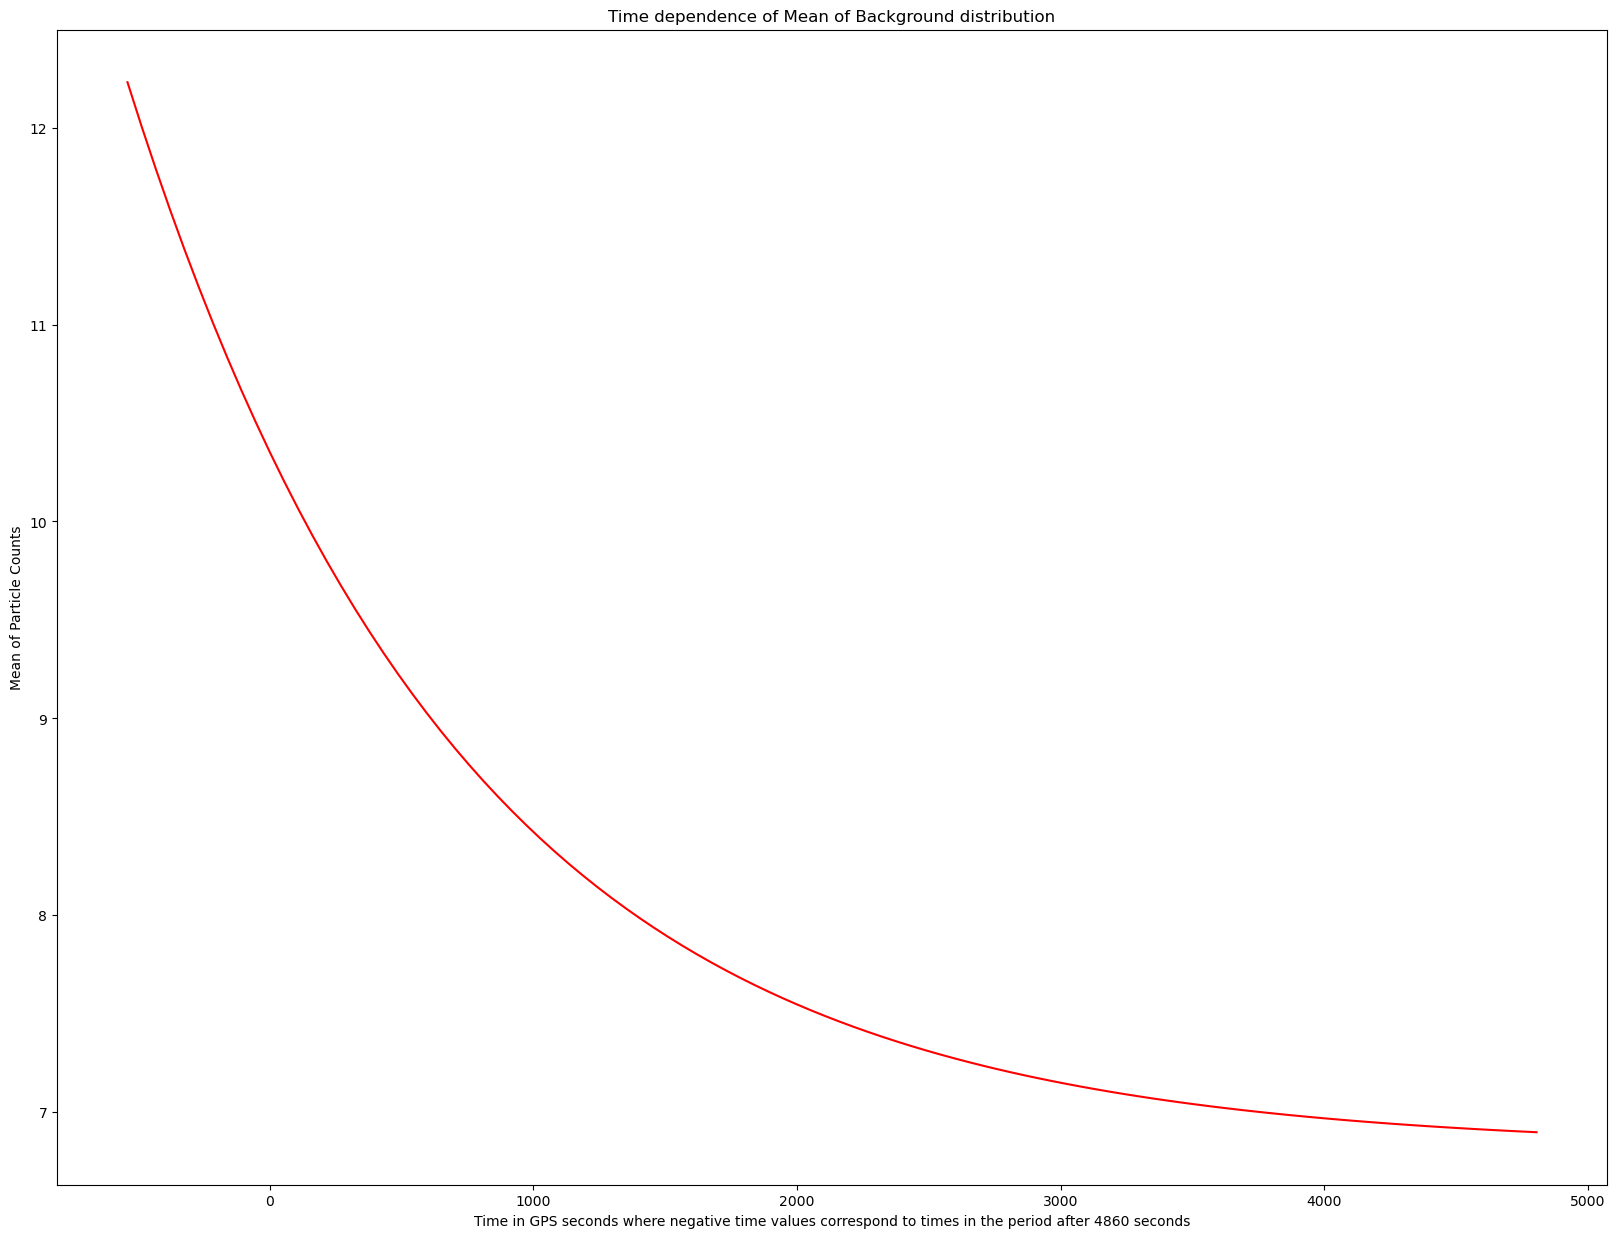

In [170]:
def func(x, a, b, c):
    return a * np.exp(-b * t*0.0666666666666667) + c

t = np.arange(-540,4860, 54)

plt.plot(t, func(t, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.ylabel('Mean of Particle Counts')
plt.xlabel('Time in GPS seconds where negative time values correspond to times in the period after 4860 seconds')
plt.title('Function of Time dependence for Mean of Background distribution')

The above plot shows how the mean of the distribution for particle counts changes according to time in GPS seconds. If the data in the histogram were shifted like this plot here, it would line up nearly exactly with the densest points along the histogram which shows the longitude dependence for the particle counts. I would say that this model for the background is a good model, as it fairly accurately shows the means based on different times, and follows the same shape as the longitude dependent curve.

In [168]:
# Problem 1.4

means = func(t, *popt)
sum = 0
for mean in means:
    threshold = stats.norm.isf(3.5*10**-6, loc=mean)
    print(threshold)
    sum += (threshold - mean)

print('Mean Threshold Difference: ',sum/100)

16.724596536636216
16.498707977752368
16.2822476604935
16.074822064530036
15.876054094466756
15.685582394291263
15.503060690436293
15.328157162261626
15.160553838811094
14.999946020748038
14.846041726418282
14.698561161033597
14.557236208010627
14.421809941540545
14.292036159503306
14.16767893587735
14.048512191831016
13.934319284715963
13.82489261421537
13.72003324493089
13.61955054472227
13.52326183814209
13.430992074335643
13.34257350880212
13.25784539843863
13.176653709312593
13.098850836631279
13.024295336399378
12.952851668276773
12.88438994916904
12.8187857171027
12.755919704955947
12.695677623633522
12.637949954291525
12.582631749234451
12.52962244112247
12.478825660142107
12.430149058807938
12.383504144076797
12.338806116469264
12.295973715905998
12.2549290739786
12.215597572386482
12.177907707282355
12.141790959279735
12.10718166888612
12.07401691713542
12.042236411202586
12.011782374792507
11.982599443103926
11.95463456217739
11.927836892444247
11.902157716301392
11.87755034

Problem 1.4

The values above are the particle counts that you would need for a 5 sigma discovery for 100 different times. The first 12 values are shifted, so they would actually occur at the end of the period for the satellites orbit around the earth. It can be seen that the mean of the difference between the actual mean, and the 5 sigma threshold is about 4.5. 

In [104]:
# Problem 2.1:

hf = h5py.File('images.h5', 'r')
print(hf.keys())
data = np.array(hf.get('imagestack'))


<KeysViewHDF5 ['image1', 'imagestack']>


(200, 200, 10)


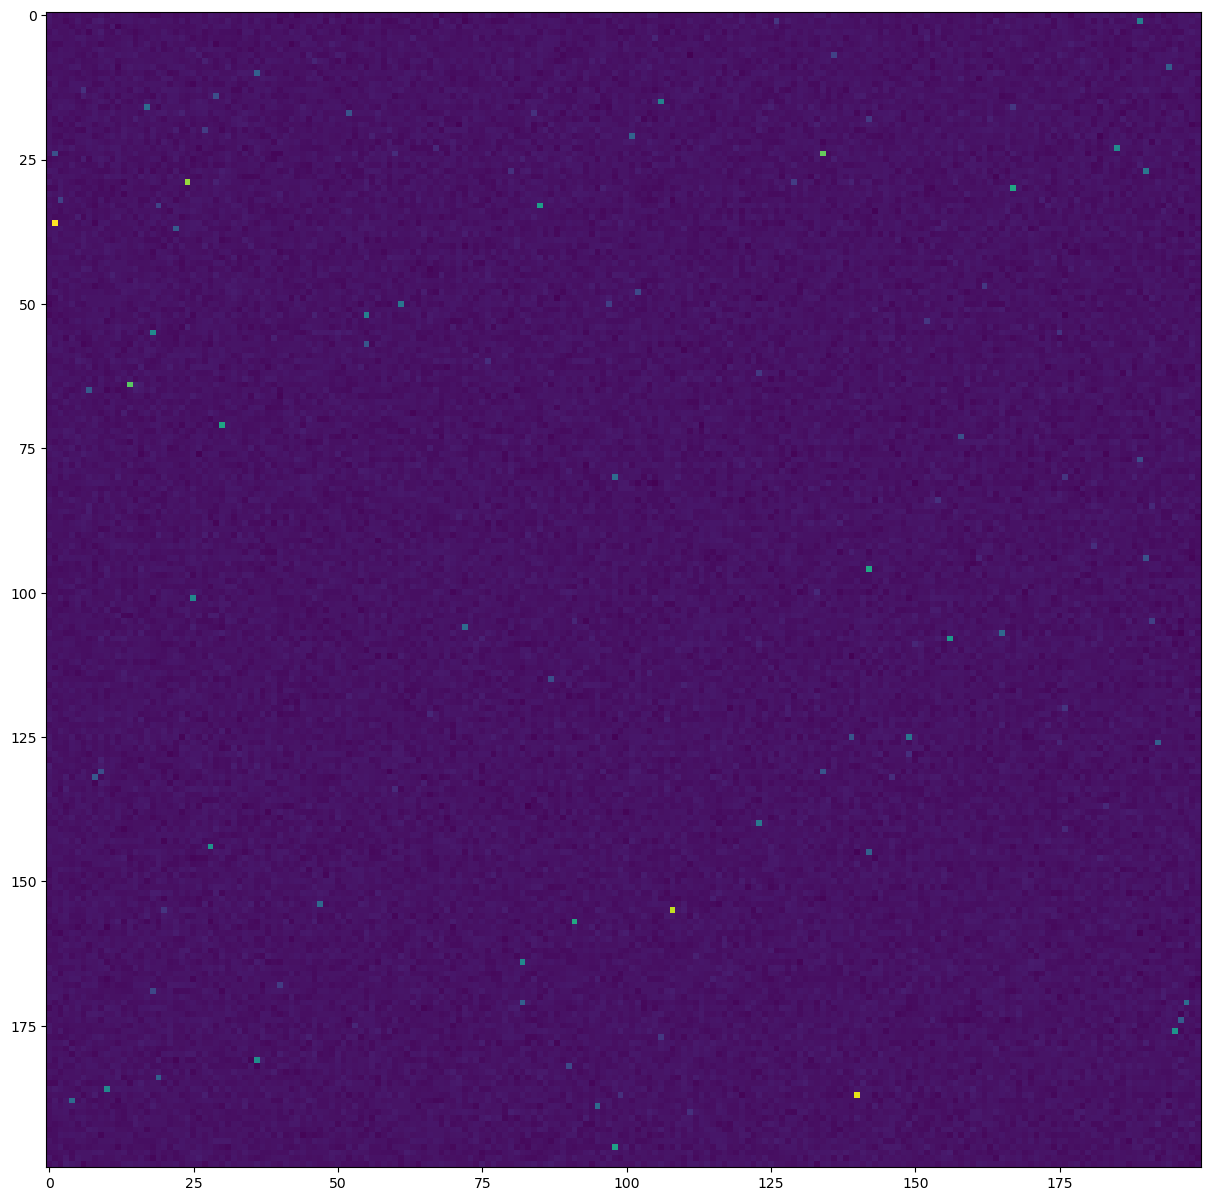

In [89]:
# Problem 2.2:

plt.imshow(data[:,:,6])
summed_images = data[:,:,0]
for i in range(1, 10):
        summed_images += data[:,:,i]

#print(data.shape)


[[  2.62523562   5.80986093   0.83955208 ...  -9.00516686   2.06260172
   -4.00194202]
 [ 18.01454983  19.30667674  -0.28641361 ...  -8.06875051  12.00460543
   27.87373154]
 [-21.10515874  -7.37462153  -8.33602459 ...  12.24535899 -10.92205645
   19.5658914 ]
 ...
 [ -6.48298959 -20.7852689    3.59054614 ...   8.84802093  -8.47993921
  -14.26905236]
 [ 18.16081783 -15.24239248 -13.81126142 ...  17.06597315   4.12498917
  -27.71672292]
 [-17.68026494   8.73827685   1.10600101 ...  28.68406124  -5.50809096
  -13.25509593]]


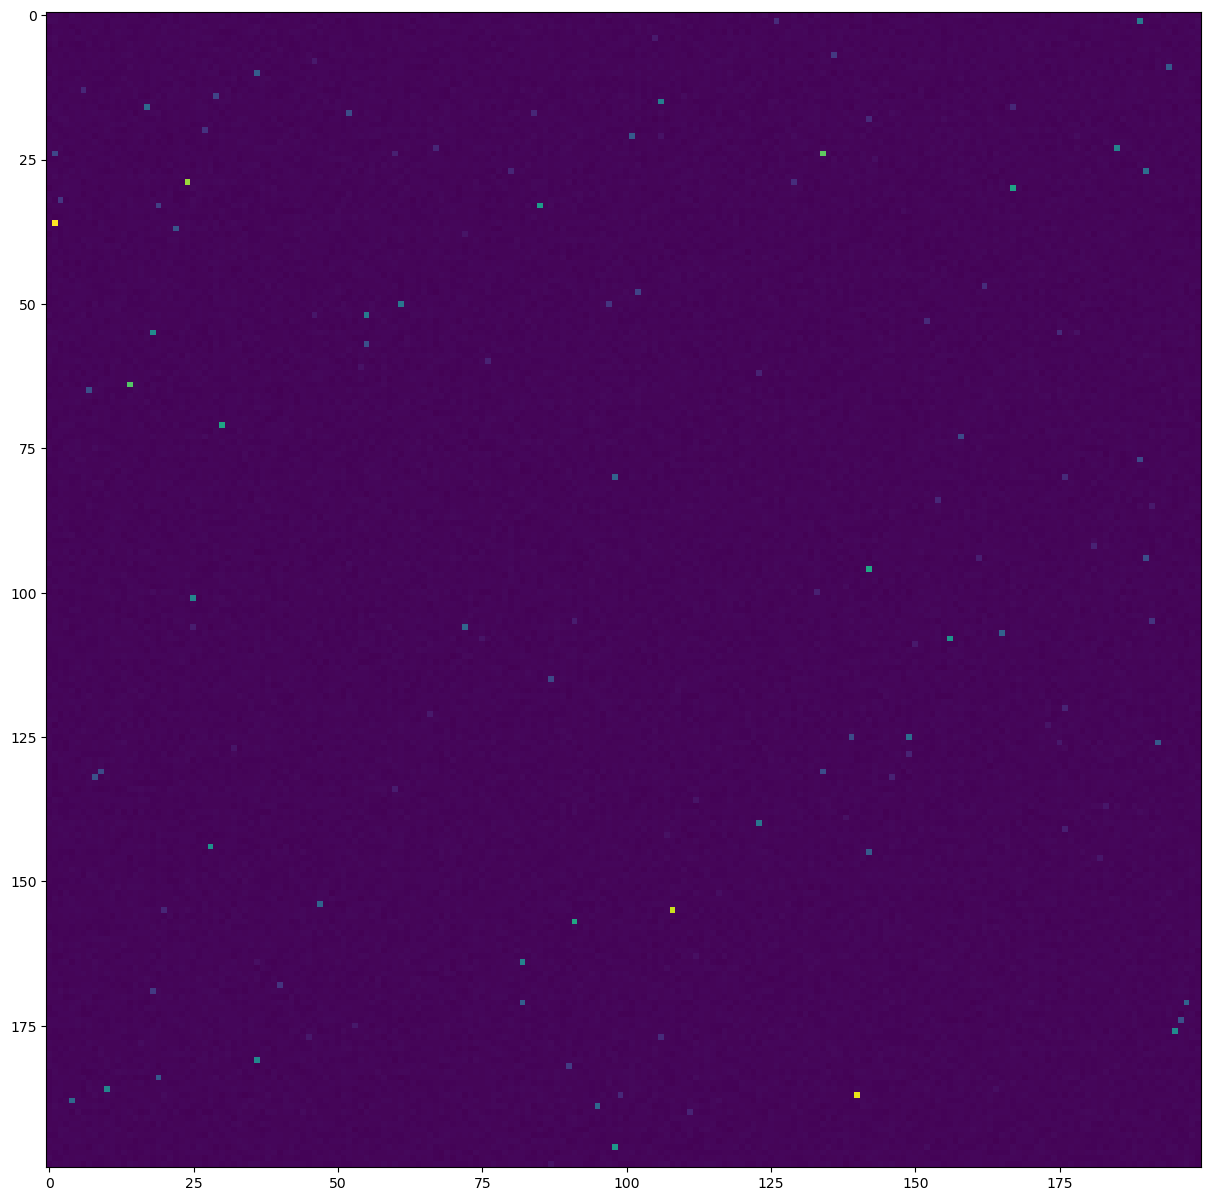

In [133]:
plt.imshow(summed_images)